<a href="https://colab.research.google.com/github/AIDA-DA/aida-project-image-scene/blob/main/notebooks/Project_Image_Scene_Classification_ResNet50_ImageSizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://storage.googleapis.com/kaggle-datasets-images/130081/310927/007f156e945286c81911147dd952ad22/dataset-cover.jpg?t=2019-03-02-09-45-36" width="100%">
<center><h1>AIDA Final Project</h1></center>
<center><p>Image Scene Classification</p></center>

We will use [this](https://www.kaggle.com/puneet6060/intel-image-classification) Kaggle dataset which contains 17k images of the 6 categories. Our goal is to develop an algorithm which can distinguish the different image categories. I this approach I will use Tensorflow Keras together with pretained models provided by the framework.

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
tf.__version__

'2.3.0'

In [3]:
!nvidia-smi

Fri Dec  4 07:02:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download & Prepare Dataset

In [4]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Download the artist dataset using the Kaggle API. In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine. Upload `kaggle.json` into Google Colab Files

In [5]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
os.chmod("/content", 600)
os.chmod("/content/kaggle.json", 600)

or set username and API-Key as enviroment variables

```
os.environ['KAGGLE_USERNAME'] = 'paulbauriegel'
os.environ['KAGGLE_KEY'] = '...'
```

Authenticate and Download Dataset from Kaggle

In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [7]:
api.dataset_download_files('puneet6060/intel-image-classification', unzip=True)

In [8]:
images_dir = '/content/seg_train/seg_train'
class_names = os.listdir(images_dir)
n_classes = len(class_names)

### Create Image Classification Model

Import some Keras functionality

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers

#### Test different image input sizes

The image input size of $150^2$ is in below the common input of $224$ of many networks.The input layer should be divisible by 2 many times. Which gives us 3 options to try out: 

1. Upscaling to $224$ 
2. Downscaling to $112=(\frac{224}{2})$ or 
3. No scaling at $150$. 

If equal results can be archived with a smaller input size that would be preferable for computational reasons.

In [27]:
# Train the model - all layers
def finetune_ResNet50(class_weights=None, 
                      full_epochs=10, fine_epochs=50, 
                      img_size=112, batch_size=256):

  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  
  train_gen = preprocess_gen.flow_from_directory(
    directory='/content/seg_train/seg_train',
    class_mode='categorical',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    classes=class_names)

  val_gen = preprocess_gen.flow_from_directory(
      directory='/content/seg_test/seg_test',
      class_mode='categorical',
      target_size=(img_size, img_size),
      batch_size=batch_size,
      shuffle=True,
      classes=class_names)
  
  # Save and convert :
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(img_size, img_size, 3))
  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.layers[-6].output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])

  history1 = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  
  # Freeze core ResNet layers and train again 
  for layer in model.layers:
      layer.trainable = False

  for layer in model.layers[-50:]:
      layer.trainable = True

  history2 = model.fit(train_gen,  #steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                       epochs=fine_epochs,
                       shuffle=True,
                       verbose=1,
                       callbacks=[reduce_lr, early_stop],
                       class_weight=class_weights )
  history = {}
  history['loss'] = history1.history['loss'] + history2.history['loss']
  history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
  history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
  history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
  history['lr'] = history1.history['lr'] + history2.history['lr']
  return model, history

#### Online Data Augumentation

In [22]:
preprocess_gen = ImageDataGenerator(rescale=1./255.,
                                    #preprocessing_function = lambda x: np.moveaxis(x, 1, -1),
                                      #rotation_range=45,
                                      #width_shift_range=0.5,
                                      #height_shift_range=0.5,
                                    shear_range=5,
                                      #zoom_range=0.7,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    )

In [23]:
# Get path of files
l = []
import itertools
for class_name in os.listdir(images_dir):
  l+= [os.path.join(class_name, x) for x in os.listdir(os.path.join(images_dir, class_name))]
l_y = [x.split('/')[0] for x in l]

#### Calculate Class weights

In [24]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', class_names, l_y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9729617304492513,
 1: 0.9311305732484076,
 2: 1.0299427564949362,
 3: 1.0285839929639402,
 4: 1.067549064354176,
 5: 0.9819479429051218}

#### Visualisation

In [25]:
# Plot the training graph
from tensorflow.keras.callbacks import History

def plot_history(history):
    if isinstance(history, History):
      history = history.history
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc)+1)

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r--', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r--', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()

### Model Training

#### Training

##### FineTuning 112

In [28]:
model_RN50_112, history_RN50_112 = finetune_ResNet50(img_size=112,
                                                     batch_size=256)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
__

In [31]:
(round(np.mean(history_RN50_112['val_accuracy'][-20:]), 4), 
 round(np.std(history_RN50_112['val_accuracy'][-20:]), 4))

(0.9282, 0.0024)

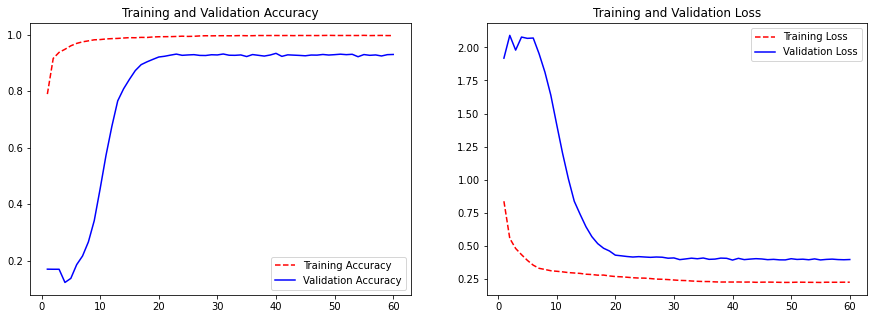

In [32]:
plot_history(history_RN50_112)

In [34]:
model_RN50_112.save('model_RN50_112.h5')

##### FineTuning 150

In [35]:
model_RN50_150, history_RN50_150 = finetune_ResNet50(img_size=150,
                                                     batch_size=196)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__

In [36]:
model_RN50_150.save('model_RN50_150.h5')

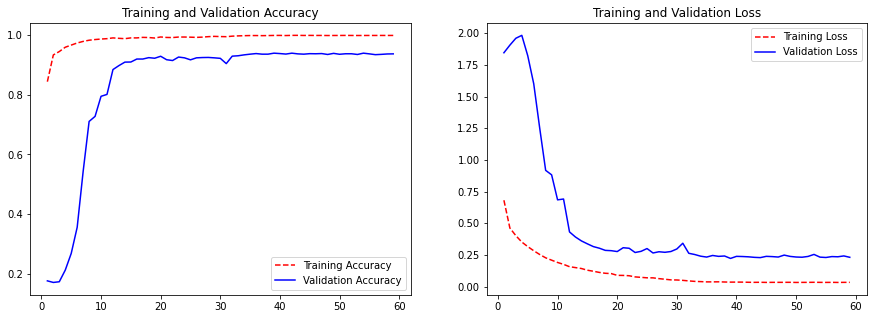

In [37]:
plot_history(history_RN50_150)

In [39]:
(round(np.mean(history_RN50_150['val_accuracy'][-20:]), 4), 
 round(np.std(history_RN50_150['val_accuracy'][-20:]), 4))

(0.9373, 0.0014)

##### FineTuning 224

In [41]:
model_RN50_224, history_RN50_224 = finetune_ResNet50(img_size=224,
                                                     batch_size=128)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__

In [ ]:
2281 9420

In [42]:
model_RN50_224.save('model_RN50_224.h5')

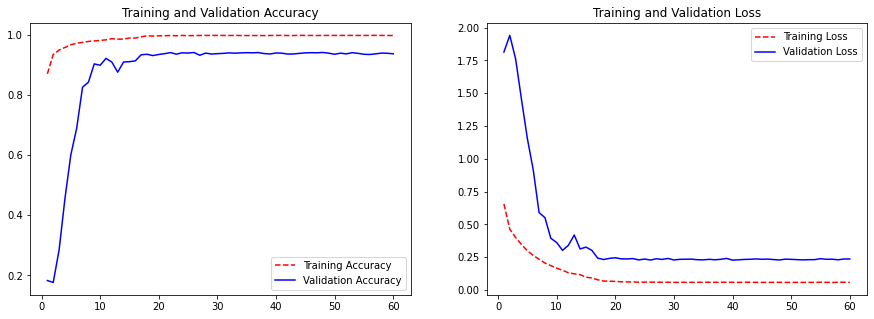

In [43]:
plot_history(history_RN50_224)

In [44]:
(round(np.mean(history_RN50_224['val_accuracy'][-20:]), 4), 
 round(np.std(history_RN50_224['val_accuracy'][-20:]), 4))

(0.9388, 0.002)

In [ ]:
model_RN50_192, history_RN50_192 = finetune_ResNet50(img_size=192,
                                                     batch_size=128)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
__

## Summary

to lazy to write one - top validation accuracy is 94% average is around 93%

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/model_ftv2_RN50.h5'

In [ ]:
model = load_model(MODEL_PATH)

In [ ]:
class_names

['glacier', 'street', 'sea', 'mountain', 'forest', 'buildings']

5
Predicted class = buildings
Prediction probability = 98.17387461662292 %


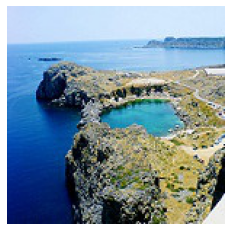

In [ ]:
import imageio
import cv2

web_image = imageio.imread('/content/seg_test/seg_test/sea/20112.jpg')
web_image = cv2.resize(web_image, dsize=(224, 224)).astype('float')
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)

prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)
print(prediction_idx)

print("Predicted class =", class_names[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread('/content/seg_test/seg_test/sea/20112.jpg'))
plt.axis('off')
plt.show()

In [ ]:
class_names = ['glacier','street', 'buildings', 'forest', 'mountain', 'sea']

In [ ]:
web_image.shape

(1, 150, 150, 3)

In [ ]:
prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

In [ ]:
model.p